In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS
from scipy.stats import beta

sns.set_palette("Set2")

In [2]:
# We will skip connecting to the reddit API and just use the voting ratios
votes = torch.tensor([[32, 3], [1918, 101], [79, 17], [33, 6]])

In [3]:
def voting_model(up, down):
    up_rate = pyro.sample("up_rate", dist.Uniform(0, 1))
    pyro.sample("rating", dist.Binomial(total_count=up + down, probs=up_rate), obs=up)

In [4]:
nuts_kernel = NUTS(voting_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

results = []

for up, down in votes:
    mcmc.run(up, down)
    results.append(mcmc.get_samples()["up_rate"].detach().cpu().numpy())

Sample: 100%|██████████| 1200/1200 [00:03, 356.30it/s, step size=1.17e+00, acc. prob=0.907]


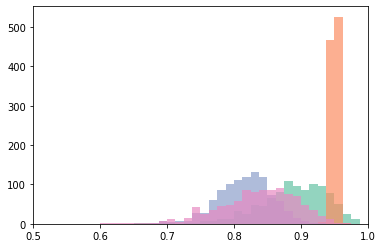

In [5]:
fig, ax = plt.subplots()

for r in results:
    ax.hist(r, bins=40, range=(0.5, 1.0), alpha=0.7)

ax.set_xlim((0.5, 1))

plt.show()

In [6]:
# The TF tutorial uses
votes_tf = torch.tensor([[45, 6], [612, 35], [335, 10], [162, 20]])

In [7]:
results_tf = []

for up, down in votes_tf:
    mcmc.run(up, down)
    results_tf.append(mcmc.get_samples()["up_rate"].detach().cpu().numpy())

Sample: 100%|██████████| 1200/1200 [00:03, 339.03it/s, step size=1.25e+00, acc. prob=0.906]


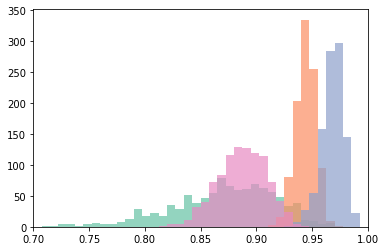

In [8]:
fig, ax = plt.subplots()

for r in results_tf:
    ax.hist(r, bins=40, range=(0.7, 1.0), alpha=0.7)

ax.set_xlim((0.7, 1))

plt.show()

In [9]:
# We know that the Beta-(1, 1) prior is conjugate to our Binomial likelihood
# This makes calculating the exact posterior distributions really easy
posterior_parameters = 1 + votes_tf.numpy()

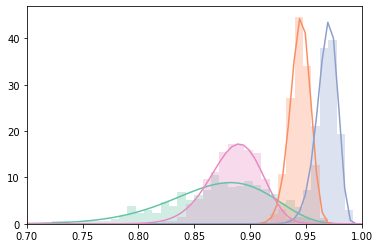

In [10]:
fig, ax = plt.subplots()

for i, r in enumerate(results_tf):
    ax.hist(r, bins=40, range=(0.7, 1.0), alpha=0.3, color=sns.color_palette()[i], density=True)

xx = np.linspace(0.5, 1.0, 100)
yy = beta.pdf(np.tile(xx, [4, 1]).T, posterior_parameters[:, 0], posterior_parameters[:, 1]).T

for i, y in enumerate(yy):
    ax.plot(xx, y, color=sns.color_palette()[i])

ax.set_xlim((0.7, 1))

plt.show()